In [1]:
#import libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#for feature scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
#split in train-test set
from sklearn.model_selection import train_test_split as split

#model evalutaion metrics
from sklearn import metrics

#for hyperparameters tuning
from sklearn.model_selection import RandomizedSearchCV

#for constructing distributions:
from scipy.stats import uniform
from scipy.stats import loguniform

import math

                                                             3rd Machine Learning Project - start2impact - Davide Miglietta

                                                                                                NOTEBOOK 4: Random Forest                                                           

# Student Alcohol Consumption

### Random Forest:

In this notebook the prediction is done using a Random Forest (RF). Treating different ML algorithms in different notebooks, let perform a more detailed analysis and optimization. Each model usually reach best performances in different conditions: for instance, RF generally deal good with high number of features and doesn't need features scaling or transformations. For this reason, Random Forest and Support Vector Regression have been studied in different notebooks and after that, compared.

## Table of contents:
1. [Data Manipulation](#1)
    - [Features and Target](#1.1)
    - [Train/Test Set Split](#1.2)


2. [Functions Definition for ML Analysis](#2)


3. [Random Forest](#3)


4. [Features Importance Evaluation](#4)
    - [Random Forest with Features Subset](#4.1)


5. [Models Comparation](#5)
    - [Results Scatterplot](#5.1)
    - [Residuals Distributions](#5.2)
    - [Metrics Comparation](#5.3)


6. [Conclusions](#6)

## 1

## Data Manipulation

In [2]:
#portuguese dataset import
df = pd.read_csv('student-por.csv')
print(df.shape)
df.head(2)

(649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11


In [3]:
'''Using Random forest, it is enough change categorical features in corresponding numbers (labels).
With LabelEncoder(), this is easily performed.'''

#assign LabelEncoder() to le
le = LabelEncoder()

#select categorical features
categorical = df.select_dtypes(include=['object'])
cat_columns = categorical.columns.tolist()

#label each sample of all categorical features
for column in cat_columns:
    df[column] = le.fit_transform(df[column])

#drop G1 and G2 as before
df=df.drop(['G1', 'G2'], axis=1)
print(df.shape)
df.head(2)

(649, 31)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,0,0,18,1,0,0,4,4,0,4,...,0,0,4,3,4,1,1,3,4,11
1,0,0,17,1,0,1,1,1,0,2,...,1,0,5,3,3,1,1,3,2,11


### 1.1

### Features and Target

In [4]:
#as said, the target y is the fianl grade G3
y = df.pop('G3')

print(y)

#a subset of features is copied
X = df.copy()
X.head(2)

0      11
1      11
2      12
3      14
4      13
       ..
644    10
645    16
646     9
647    10
648    11
Name: G3, Length: 649, dtype: int64


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,0,0,18,1,0,0,4,4,0,4,...,1,0,0,4,3,4,1,1,3,4
1,0,0,17,1,0,1,1,1,0,2,...,1,1,0,5,3,3,1,1,3,2


### 1.2

### Train/Test Set Split

In [5]:
#setting same conditions for replicabilty: test_size =.2, random_state=0

X_train, X_test, y_train, y_test = split(X, y, test_size =.2, random_state=0) 

print(X.shape)
print(X_train.shape)
print(X_test.shape)
print('****************')
print(y.shape)
print(y_train.shape)
print(y_test.shape)

(649, 30)
(519, 30)
(130, 30)
****************
(649,)
(519,)
(130,)


In [6]:
X_train.head(2)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
34,0,1,16,1,0,1,3,2,2,2,...,1,1,0,5,4,3,1,1,5,4
432,1,0,17,0,0,1,1,1,2,2,...,0,1,0,5,4,4,2,2,5,0


## 2

## Functions Definition for ML Analysis

Functions of notenook 2 are re-used.

In [7]:
def random_search(model, parameters, k, scoring, N):
       
    rs = RandomizedSearchCV(model, parameters, cv = k, scoring = scoring, n_iter = N, verbose = 50, n_jobs = -1) 
    rs = rs.fit(X_train,y_train)
    
    #'model_dict' is a dictionary containing all results of RandomizedSearchCV() for an easier later consultation
    model_dict = {}
    model_dict['best_score'] = rs.best_score_
    model_dict['best_params'] = rs.best_params_
    
    model_dict['params'] = rs.cv_results_['params']
    model_dict['means'] = rs.cv_results_['mean_test_score']
    model_dict['stds'] = rs.cv_results_['std_test_score']
        
    model_dict['MAE_train'] = metrics.mean_absolute_error(y_train, rs.predict(X_train))
    model_dict['MSE_train'] = metrics.mean_squared_error(y_train, rs.predict(X_train))
    model_dict['RMSE_train'] = np.sqrt(metrics.mean_squared_error(y_train, rs.predict(X_train)))
    model_dict['r2_train'] = np.sqrt(metrics.r2_score(y_train, rs.predict(X_train)))
    
    model_dict['MAE_test'] = metrics.mean_absolute_error(y_test, rs.predict(X_test))
    model_dict['MSE_test'] = metrics.mean_squared_error(y_test, rs.predict(X_test))
    model_dict['RMSE_test'] = np.sqrt(metrics.mean_squared_error(y_test, rs.predict(X_test)))
    model_dict['r2_test'] = np.sqrt(metrics.r2_score(y_test, rs.predict(X_test)))
        
    best_model = rs.best_estimator_
    
    return best_model, model_dict

In [8]:
def see_randomsearch_results(x, model_dict, regr_model):
    
    print('Best Model:', regr_model)
    print('\nBest score ({}): {:.2f}'.format(scoring, model_dict['best_score']))
    
    #to organize in descending order the results of the RandomizedSearchCV()
    #and organize consequently the corresponding standard deviations and list of parameters
    
    means = list(model_dict['means'])
    stds = list(model_dict['stds'])
    params = list(model_dict['params'])
     
    sorted_lists = sorted(zip(means, stds, params), reverse = True, key = lambda l:l[0])
    tuples = zip(*sorted_lists)
    sorted_means, sorted_stds, sorted_params = [ list(tuple) for tuple in  tuples]
    
    plt.figure(figsize=(20, 4))
    
    #plot a point corresponding to the score and a bar corresponding to the std dev for each group of parameters
    plt.errorbar(np.arange(x), sorted_means[:x], yerr=sorted_stds[:x], fmt='o', ms=15,
                 ecolor='green', capsize=15, capthick=3)
    plt.xticks(np.arange(x))
    
    plt.show()

    print('Chart Legend:\n')
    
    for i in np.arange(x):
        print('{} --> Hyperparameters: {}'.format(i, sorted_params[i]))

### Functions parameters

In [9]:
print(metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])


In [10]:
k = 5 #k-folds for cross validation

'''As discriminating metric it has ben chosed the mean squared error, since it has been noticed that,
the model has worst performances for high grades. In this way we try to minimize big errors.'''

scoring = 'neg_mean_squared_error'

N = 200 #number of iterations (combination of hyperparameters)


## 3

## Random Forest

Hyperparameters: 

- **n_estimators:** Number of single trees in the random forest. Ideally, the higher the better. However, above a certain threshold improvement is not significant anymore, while computational time increases. So it's important to find the right compromise.
- **max features:** numbers of features considered for splitting. This is the most important hyperparameter for a random forest. The single trees could present high variance but, since in each tree we are -randomly- not considering all the features and we are combining many different trees, the result is a sensible decrease in variance (overfitting) but only a small increase in bias (underfitting).

- **min_samples_leaf, min_samples_split and max depth** can be also validated

In [11]:
math.ceil(X.shape[0] * 0.003)
#math.ceil(X.shape[0] * 0.01)

2

In [12]:
from sklearn.ensemble import RandomForestRegressor 

regressor = RandomForestRegressor(random_state=0)


parameters = {'n_estimators': [100, 500],
              'max_features':np.arange(1,int(df.shape[1]/2)),
             'min_samples_split': loguniform(0.03,0.25),
             #'min_samples_leaf':loguniform(0.003,0.25)
             }


RF_model, RF_dict = random_search(regressor, parameters, k, scoring, N)

RF_predictions = RF_model.predict(X_test)

print('\nDone!')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   41.8s
[Paralle

[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:  1.3min
[Paralle

[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 414 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 415 tasks      | elapsed:  1.8min
[Paralle

[Parallel(n_jobs=-1)]: Done 533 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 534 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 535 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 539 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 547 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed:  2.8min
[Paralle

[Parallel(n_jobs=-1)]: Done 666 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 667 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 671 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 673 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 675 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 678 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 679 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed:  3.6min
[Paralle

[Parallel(n_jobs=-1)]: Done 799 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 801 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 802 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 803 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 805 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 806 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 807 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 809 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 813 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 814 tasks      | elapsed:  4.3min
[Paralle

[Parallel(n_jobs=-1)]: Done 932 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 933 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 934 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 935 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 937 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 938 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 939 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 940 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 941 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 942 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 943 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 945 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 946 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 947 tasks      | elapsed:  4.9min
[Paralle

Best Model: RandomForestRegressor(max_features=13, min_samples_split=0.038758755353469454,
                      random_state=0)

Best score (neg_mean_squared_error): -7.47


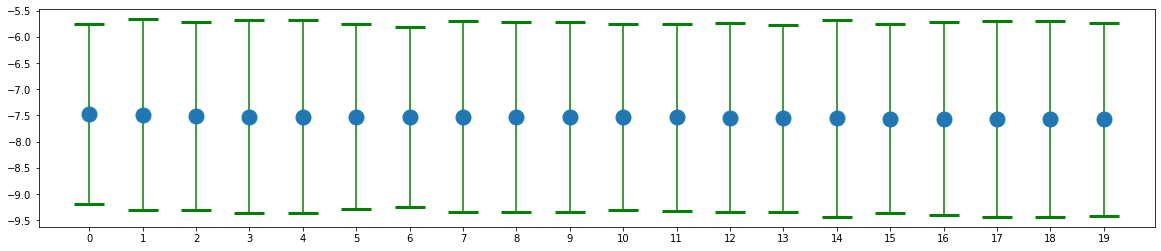

Chart Legend:

0 --> Hyperparameters: {'max_features': 13, 'min_samples_split': 0.038758755353469454, 'n_estimators': 100}
1 --> Hyperparameters: {'max_features': 8, 'min_samples_split': 0.0313006946204549, 'n_estimators': 500}
2 --> Hyperparameters: {'max_features': 11, 'min_samples_split': 0.03802678892138301, 'n_estimators': 500}
3 --> Hyperparameters: {'max_features': 11, 'min_samples_split': 0.03753985226377143, 'n_estimators': 100}
4 --> Hyperparameters: {'max_features': 11, 'min_samples_split': 0.037683940574959156, 'n_estimators': 100}
5 --> Hyperparameters: {'max_features': 11, 'min_samples_split': 0.05054808050734483, 'n_estimators': 100}
6 --> Hyperparameters: {'max_features': 13, 'min_samples_split': 0.041741848949185034, 'n_estimators': 500}
7 --> Hyperparameters: {'max_features': 10, 'min_samples_split': 0.046354976697718285, 'n_estimators': 500}
8 --> Hyperparameters: {'max_features': 10, 'min_samples_split': 0.049834127762168515, 'n_estimators': 100}
9 --> Hyperparamete

In [13]:
see_randomsearch_results(20, RF_dict, RF_model)

## 4

## Features Importance Evaluation

In [14]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(RF_model, X_test, y_test, 
                                         scoring=scoring, n_repeats=10, n_jobs=-1, random_state=0)

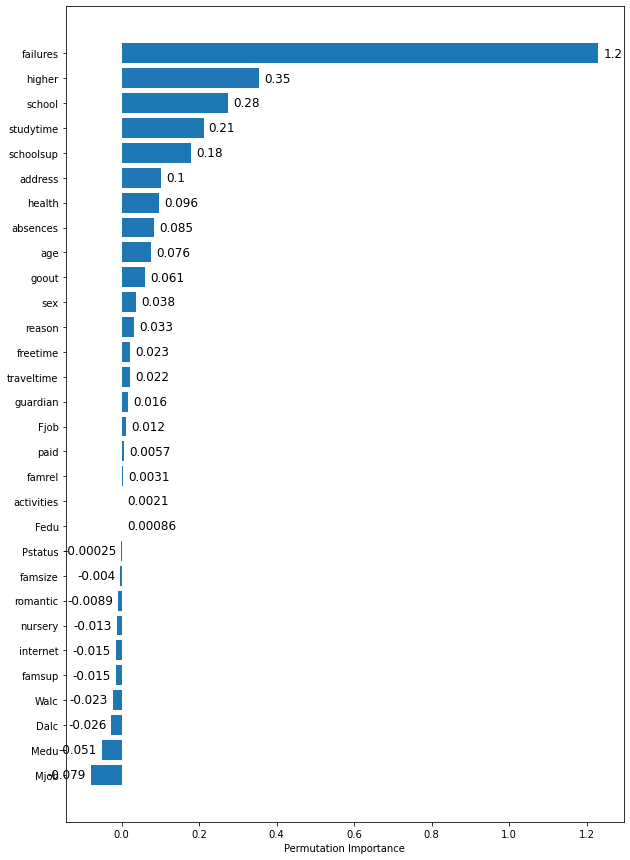

In [15]:
sorted_idx = perm_importance.importances_mean.argsort()
imp = perm_importance.importances_mean[sorted_idx]


fig, ax = plt.subplots(figsize=(10,15))
hbar=plt.barh(X.columns[sorted_idx], imp)
plt.bar_label(hbar, size=12, padding=5, labels=['{:.2}'.format(a) for a in imp])
plt.xlabel('Permutation Importance')

plt.show()

The first 15 more important features are selected.

In [16]:
columns=X.columns[sorted_idx][-15:]
print(columns)

X_train = X_train[columns]
X_test = X_test[columns]

X_train.head(2)

Index(['guardian', 'traveltime', 'freetime', 'reason', 'sex', 'goout', 'age',
       'absences', 'health', 'address', 'schoolsup', 'studytime', 'school',
       'higher', 'failures'],
      dtype='object')


,guardian,traveltime,freetime,reason,sex,goout,age,absences,health,address,schoolsup,studytime,school,higher,failures
34,1,1,4,1,1,3,16,4,5,1,0,1,0,1,0
432,0,1,4,2,0,4,17,0,5,0,0,1,1,0,1


### 4.1

### Random Forest with Features Subset

Similar to what done in SVR notebook:

In [17]:
'''First we get the parameters and create a new dictionary, called model_parameters.
We keep only the ones that are of interest, with attention that the values are lists (for the function to work).'''

model_parameters = RF_model.get_params()
print(model_parameters.keys())

for p in list(model_parameters.keys()):
    if p not in ['n_estimators', 'max_features', 'min_samples_split']:
        model_parameters.pop(p)
    else:
        value = model_parameters[p]
        model_parameters[p] = []
        model_parameters[p].append(value)


model_parameters

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])


{'max_features': [13],
 'min_samples_split': [0.038758755353469454],
 'n_estimators': [100]}

In [18]:
#applying the function with one set of parameters
regressor = RandomForestRegressor(random_state=0)

parameters = model_parameters

RF_model_subset, RF_dict_subset = random_search(regressor, parameters, k, scoring, 1) #one iteration

RF_predictions_subset = RF_model_subset.predict(X_test)

print('\nDone!')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished

Done!


Best Model: RandomForestRegressor(max_features=13, min_samples_split=0.038758755353469454,
                      random_state=0)

Best score (neg_mean_squared_error): -7.78


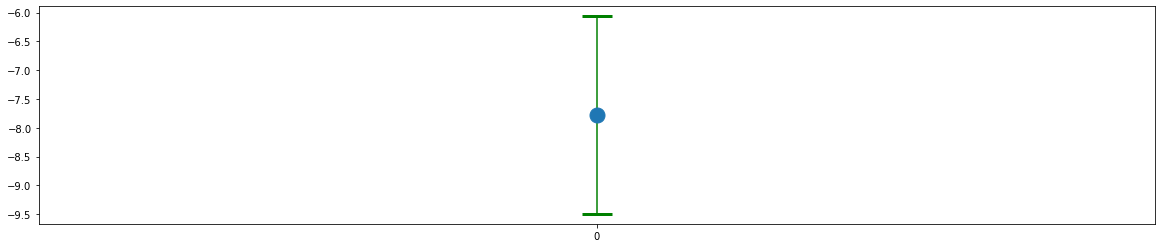

Chart Legend:

0 --> Hyperparameters: {'n_estimators': 100, 'min_samples_split': 0.038758755353469454, 'max_features': 13}


In [19]:
see_randomsearch_results(1, RF_dict_subset, RF_model_subset)

Now we are ready to  compare results obtained using all features and ones obtained with just a subset.

### 5

### Models Comparation

In this section the results obtained will be compared in order to find the model with the best performance.

In [20]:
#the following lists are creating for an easier iteration of the following part

#those three lists should be of the same length and contains model information in the same order
#then all the rest is 'automatically' arranged
models = ['Random Forest', 'Random Forest Subset']
dicts = [RF_dict, RF_dict_subset]
regr_predictions = [RF_predictions, RF_predictions_subset]

name_metrics = ['Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'r2' ]
train_metrics = ['MAE_train', 'MSE_train', 'RMSE_train', 'r2_train']
test_metrics = ['MAE_test', 'MSE_test', 'RMSE_test', 'r2_test']

### 5.1

### Results scatterplots

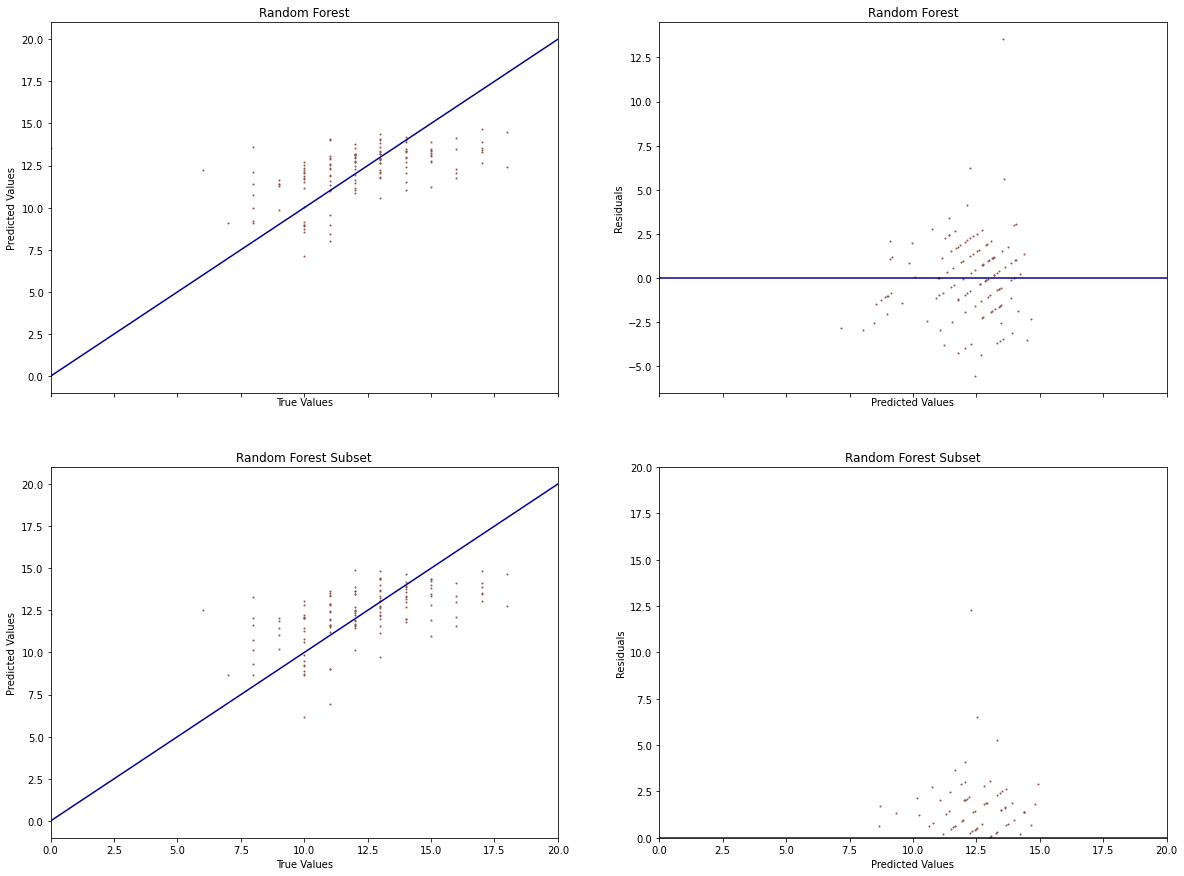

In [21]:
i = 0

fig, axes = plt.subplots(nrows = len(regr_predictions), ncols = 2, sharex = True, figsize = (20,15))

for pred, ax in zip(regr_predictions, axes):
    
    ax1 = ax[0]
    ax1.scatter(y_test, regr_predictions[i], s=1, c = 'tab:brown') #color is fixed: brown as in the secod notebook for RF
    ax1.plot([0, 20], [0, 20], color='darkblue')
    
    ax1.set_xlabel('True Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title(models[i])
    
    residuals = pred - y_test
    
    ax2 = ax[1]
    ax2.scatter(pred, residuals, s=1, c = 'tab:brown')
    ax2.axhline(color='darkblue')

    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title(models[i])
    i = i + 1

plt.xlim([0,20])
plt.ylim([0,20])
plt.show()

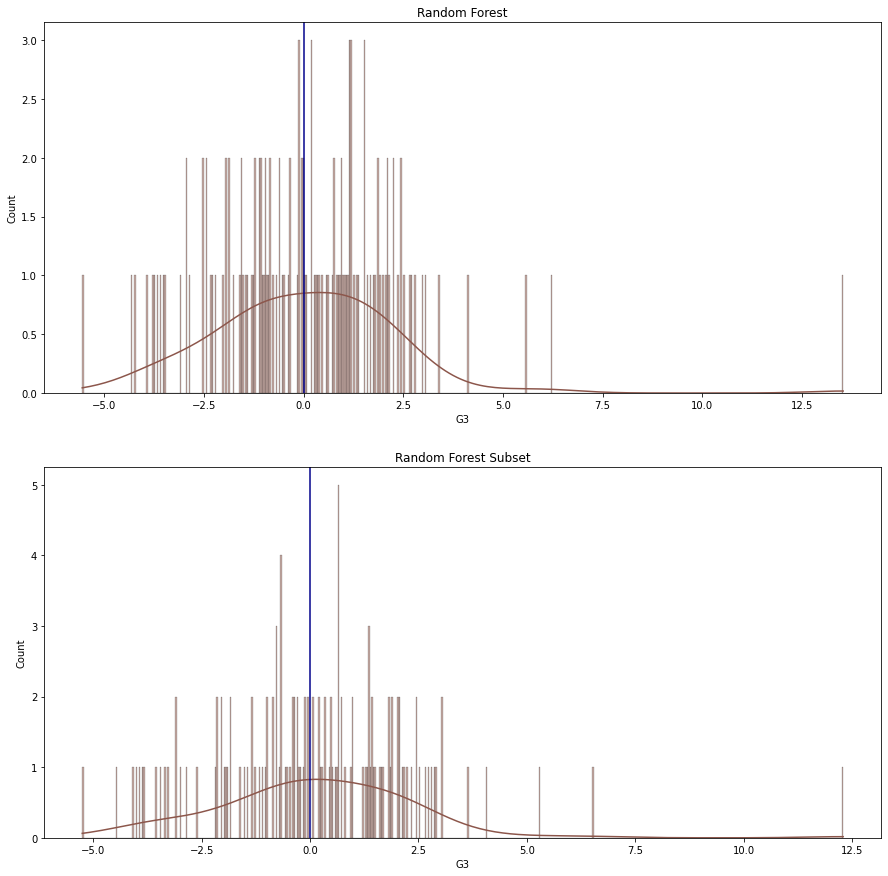

In [22]:
i = 0

fig, axes = plt.subplots(nrows = len(regr_predictions), ncols = 1, figsize = (15,15))

for pred, ax in zip(regr_predictions, axes):
    residuals = pred - y_test
    sns.histplot(residuals, bins=500, kde = True, ax=ax, color='tab:brown')
    ax.axvline(color = 'darkblue')
    ax.set_title(models[i])
    i = i + 1

### 4.3

### Metrics Comparation

- the circle marker refers to the Train Set
- the star marker refers to the Test Set

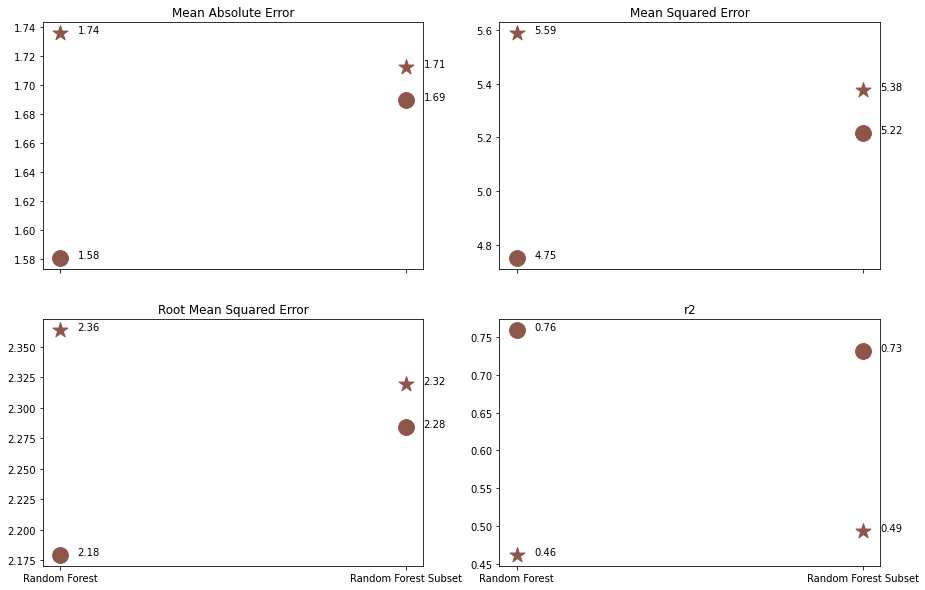

In [23]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex =True, figsize = (15,10))

for ax, train_metric, test_metric, metric in zip(axes.flat, train_metrics, test_metrics, name_metrics):
    
    for d, i, model in zip(dicts, range(len(dicts)), models):
        
        #print('Model: {} - Metric: {} - Value: {:.2f}\n'.format(model, metric, d[train_metric]))
        
        ax.scatter(x = i, y = d[train_metric], marker = 'o', color = 'tab:brown', s = 250)
        ax.annotate(str('{:.2f}'.format(d[train_metric])),( i + 0.05, d[train_metric]))
        
        ax.scatter(x = i, y = d[test_metric], marker = '*', color = 'tab:brown', s = 250)
        ax.annotate(str('{:.2f}'.format(d[test_metric])),( i + 0.05, d[test_metric]))
        
        ax.set_title(metric)
        
plt.xticks(range(len(dicts)),models)

plt.show()


Slight improvement is visible, since for test set: mean absolute and mean squared errors are lower, while r2 is higher.

## 6

## Conclusions

Random Forest, after features selection, presented the better results, compared to other models.